## Just test if we can do stokes flow on a 3d cube

### 0. Import packages

In [92]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *

%matplotlib widget

### 1. Create the starting functions and meshes

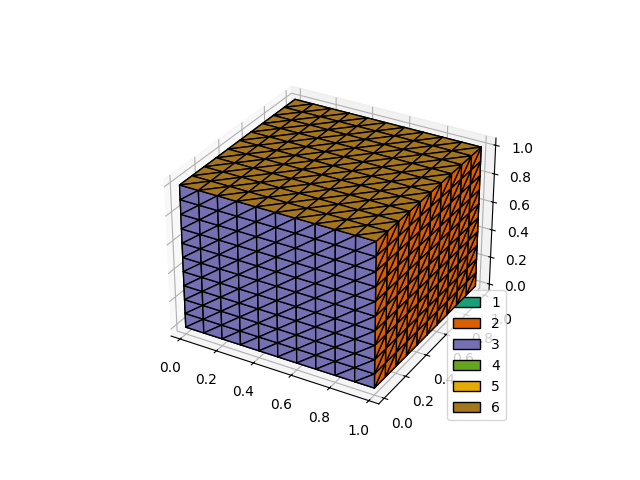

In [93]:
nx, ny, nz = 10, 10, 10

mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

firedrake.triplot(mesh)
plt.legend()
plt.show()

### 2. Set up the function spaces

In [94]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space
y = firedrake.Function(Y)
u, p = firedrake.split(y)
v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx



### 3. boundary conditions on the faces

In [95]:
face_ids = list(range(1, 7))

bc_stokes = []
for id in face_ids:

    bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundary
    bc_stokes.append(bc)

### 4. Solve the stokes problem

In [96]:


basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

### 5. Plot the results

In [105]:
# Make the grid
samp_step = 0.2
x_coords = np.arange(0, 1+samp_step, samp_step)
y_coords = np.arange(0, 1+samp_step, samp_step)
z_coords = np.arange(0, 1+samp_step, samp_step)

x_mesh, y_mesh, z_mesh = np.meshgrid(x_coords,
                                     y_coords,
                                     z_coords)

In [106]:
u_solve, v_solve, w_solve = np.meshgrid(np.zeros_like(x_coords),
                                        np.zeros_like(y_coords),
                                        np.zeros_like(z_coords))


In [107]:
for i,x_p in enumerate(x_coords):
    for j,y_p in enumerate(y_coords):
        for k,z_p in enumerate(z_coords):
            u_solve[i,j,k] = y.at((x_p, y_p, z_p))[0][0]
            v_solve[i,j,k] = y.at((x_p, y_p, z_p))[0][1]
            w_solve[i,j,k] = y.at((x_p, y_p, z_p))[0][2]

Text(0.5, 0, 'Z-axis Label')

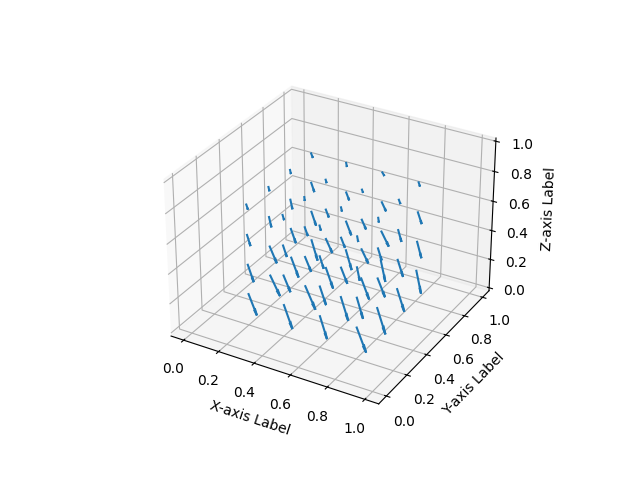

In [108]:
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(x_mesh, y_mesh, z_mesh, u_solve, v_solve, w_solve, length=1e27, normalize=False)

# Set the axis labels
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_zlabel('Z-axis Label')


### 5. Save the results

In [26]:
output_file = firedrake.output.VTKFile("flowfield_cube.pvd")
output_file.write(y.sub(0))